In [88]:
import numpy as np
import pandas as pd 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import plotly.express as px

pd.set_option('display.float_format', '{:,.2f}'.format)

## Data Loading

In [2]:
used_columns = ["pemda", "nama_pemda", "jenis_pemda", "nama_fungsi", "kategori_sub_kegiatan", "kode_akun_utama", "nilai_anggaran"]
column_types = {
    "pemda": pd.StringDtype(),
    "nama_pemda": pd.StringDtype(),
    "jenis_pemda": pd.CategoricalDtype(),
    "nama_fungsi": pd.StringDtype(),
    "kategori_sub_kegiatan": pd.CategoricalDtype(),
    "kode_akun_utama": pd.CategoricalDtype(),
    "nilai_anggaran": float
}

df = pd.read_parquet("dataset/L2_apbd_clean.parquet")
df = df.astype(column_types)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5242575 entries, 0 to 5242574
Data columns (total 7 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   pemda                  string  
 1   nama_pemda             string  
 2   jenis_pemda            category
 3   nama_fungsi            string  
 4   kategori_sub_kegiatan  category
 5   kode_akun_utama        category
 6   nilai_anggaran         float64 
dtypes: category(3), float64(1), string(3)
memory usage: 175.0 MB


In [3]:
df.head()

,pemda,nama_pemda,jenis_pemda,nama_fungsi,kategori_sub_kegiatan,kode_akun_utama,nilai_anggaran
0,ACEH,PROVINSI ACEH,PROVINSI,PARIWISATA DAN BUDAYA,LAINNYA,5,"50,500,000.00"
1,ACEH,PROVINSI ACEH,PROVINSI,PARIWISATA DAN BUDAYA,LAINNYA,5,"598,965,456.00"
2,ACEH,PROVINSI ACEH,PROVINSI,KETERTIBAN DAN KETENTRAMAN,LAINNYA,5,"6,250,000.00"
3,RIAU,PROVINSI RIAU,PROVINSI,PARIWISATA DAN BUDAYA,LAINNYA,5,"4,400,000.00"
4,PEKANBARU,KOTA PEKANBARU,KOTA,KESEHATAN LAINNYA,LAINNYA,5,"1,075,830.00"


## Preprocessing (L2)

In [4]:
# Feature construction
sub_pendidikan = [
    "PENINGKATAN KUALITAS PENGAJARAN DAN PEMBELAJARAN",
    "PROFESIONALISME DAN KUALITAS NADIK",
    "TATA KELOLA PENDIDIKAN",
    "PEMERATAAN AKSES LAYANAN PENDIDIKAN",
    "GAJI DAN TUNJANGAN",
    "LAINNYA"
]
sub_kesehatan = [
    "PENINGKATAN LAYANAN KESEHATAN DASAR DAN RUJUKAN",
    "PENGUATAN TATA KELOLA KESEHATAN",
    "GAJI DAN TUNJANGAN",
    "PENINGKATAN KOMPETENSI NAKES",
    "DAYA SAING FARMASI DAN ALAT KESEHATAN",
    "PENGAWASAN OBAT DAN MAKANAN",
    "LAINNYA"
]

In [70]:
df_pemda_grouping = df.groupby("nama_pemda")
df_pemda = df.groupby("nama_pemda").sum()

df_pemda["porsi_subdik"] = df_pemda_grouping.apply(lambda x: x[x["kategori_sub_kegiatan"].isin(sub_pendidikan[:-1])]["nilai_anggaran"].sum())
df_pemda["total_subdik"] = df_pemda_grouping.apply(lambda x: x[x["kategori_sub_kegiatan"].isin(sub_pendidikan)]["nilai_anggaran"].sum())
df_pemda["porsi_subkes"] = df_pemda_grouping.apply(lambda x: x[x["kategori_sub_kegiatan"].isin(sub_kesehatan[:-1])]["nilai_anggaran"].sum())
df_pemda["total_subkes"] = df_pemda_grouping.apply(lambda x: x[x["kategori_sub_kegiatan"].isin(sub_kesehatan)]["nilai_anggaran"].sum())

df_pemda["anggaran_kes"] = df_pemda_grouping.apply(lambda x: x[x["nama_fungsi"] == "KESEHATAN"]["nilai_anggaran"].sum())
df_pemda["anggaran_dik"] = df_pemda_grouping.apply(lambda x: x[x["nama_fungsi"] == "PENDIDIKAN"]["nilai_anggaran"].sum())

df_pemda["belanja"] = df_pemda_grouping.apply(lambda x: x[x["kode_akun_utama"] == "5"]["nilai_anggaran"].sum())
df_pemda["pendapatan"] = df_pemda_grouping.apply(lambda x: x[x["kode_akun_utama"] == "4"]["nilai_anggaran"].sum())

df_pemda = df_pemda.reset_index()
df_pemda = df_pemda.replace(np.inf, 0).fillna(0)

In [71]:
df_pemda["rasio_dik"] = (df_pemda["anggaran_dik"] / df_pemda["belanja"]) * 100
df_pemda["rasio_kes"] = (df_pemda["anggaran_kes"] / df_pemda["belanja"]) * 100

df_pemda["rasio_belanja_pendapatan"] = (df_pemda["belanja"] / df_pemda["pendapatan"]) * 100

df_pemda["rasio_porsi_kes"] = (df_pemda["porsi_subkes"] / df_pemda["total_subkes"]) * 100
df_pemda["rasio_porsi_dik"] = (df_pemda["porsi_subdik"] / df_pemda["total_subdik"]) * 100

df_pemda = df_pemda.replace(np.inf, 0).fillna(0)

In [72]:
df_pemda.head()

,nama_pemda,nilai_anggaran,porsi_subdik,total_subdik,porsi_subkes,total_subkes,anggaran_kes,anggaran_dik,belanja,pendapatan,rasio_dik,rasio_kes,rasio_belanja_pendapatan,rasio_porsi_kes,rasio_porsi_dik
0,KAB KONAWE KEPULAUAN,"1,039,516,277,046.00","138,507,624,256.00","998,635,469,820.00","145,085,518,870.00","1,005,213,364,434.00","44,554,794,682.00","60,715,518,397.00","519,758,138,523.00","518,758,138,523.00",11.68,8.57,100.19,14.43,13.87
1,KAB MOROWALI UTARA,"2,275,463,686,972.00","463,496,738,760.00","2,175,725,409,979.00","487,906,501,875.00","2,200,135,173,094.00",0.00,0.00,"1,133,531,843,486.00","1,116,141,561,762.00",0.00,0.00,101.56,22.18,21.30
2,KAB MUSI RAWAS UTARA,"1,798,210,654,000.00","294,654,373,133.00","1,765,282,000,768.00","264,557,238,508.00","1,735,184,866,143.00",0.00,0.00,"899,105,327,000.00","869,105,327,000.00",0.00,0.00,103.45,15.25,16.69
3,KAB. ACEH BARAT,"2,589,035,742,152.00","533,060,774,878.00","2,521,289,063,015.00","524,019,198,936.00","2,512,247,487,073.00","74,354,623,021.00","82,949,595,553.00","1,294,517,871,076.00","1,243,508,605,754.00",6.41,5.74,104.10,20.86,21.14
4,KAB. ACEH BARAT DAYA,"2,020,089,685,094.00","413,526,170,185.00","1,983,637,853,372.00","353,109,622,287.00","1,923,221,305,474.00","45,607,394,770.00","91,541,758,051.00","1,000,044,842,547.00","898,637,580,732.00",9.15,4.56,111.28,18.36,20.85


In [73]:
df_nama_jenis_pemda = df[["nama_pemda", "pemda", "jenis_pemda"]]
df_nama_jenis_pemda = df_nama_jenis_pemda.groupby("nama_pemda").first().reset_index()
df_pemda_full = pd.merge(df_pemda, df_nama_jenis_pemda, on="nama_pemda", how="inner")

In [74]:
column_ordered = [
    "pemda",
    "nama_pemda",
    "jenis_pemda",
    "nilai_anggaran",
    "porsi_subdik",
    "total_subdik",
    "porsi_subkes",
    "total_subkes",
    "anggaran_kes",
    "anggaran_dik",
    "belanja",
    "pendapatan",
    "rasio_dik",
    "rasio_kes",
    "rasio_belanja_pendapatan",
    "rasio_porsi_kes",
    "rasio_porsi_dik"
]

df_pemda_full = df_pemda_full[column_ordered]
df_pemda_full.to_csv("pemda_processed.csv", index=None)

## Clustering

In [75]:
df_risiko = df_pemda_full.copy()
df_risiko["risiko_defisit"] = df_risiko["rasio_belanja_pendapatan"]
df_risiko["risiko_mandatory_spending"] = (df_risiko["rasio_dik"] + df_risiko["rasio_kes"]) / 2.0
df_risiko["risiko_keselarasan"] = (df_risiko["rasio_porsi_dik"] + df_risiko["rasio_porsi_kes"]) / 2.0
df_risiko = df_risiko.drop(columns=column_ordered[3:])
df_risiko.head()

,pemda,nama_pemda,jenis_pemda,risiko_defisit,risiko_mandatory_spending,risiko_keselarasan
0,KAB KONAWE KEPULAUAN,KAB KONAWE KEPULAUAN,KABUPATEN,100.19,10.13,14.15
1,KAB MOROWALI UTARA,KAB MOROWALI UTARA,KABUPATEN,101.56,0.00,21.74
2,KAB MUSI RAWAS UTARA,KAB MUSI RAWAS UTARA,KABUPATEN,103.45,0.00,15.97
3,ACEH BARAT,KAB. ACEH BARAT,KABUPATEN,104.10,6.08,21.00
4,ACEH BARAT DAYA,KAB. ACEH BARAT DAYA,KABUPATEN,111.28,6.86,19.60


In [76]:
fig = px.scatter_3d(df_risiko, x="risiko_defisit", y="risiko_mandatory_spending", z="risiko_keselarasan", color="jenis_pemda", hover_data=["nama_pemda"])
fig.update_layout(autosize=False, height=800, width=1600, margin=dict(l=20, r=20, t=20, b=20))
fig.show()

In [92]:
df_risiko_nonzero = df_risiko[~(df_risiko==0).any(axis=1)]
df_risiko_nonzero.head()

,pemda,nama_pemda,jenis_pemda,risiko_defisit,risiko_mandatory_spending,risiko_keselarasan,cluster
0,KAB KONAWE KEPULAUAN,KAB KONAWE KEPULAUAN,KABUPATEN,100.19,10.13,14.15,2
7,ACEH SELATAN,KAB. ACEH SELATAN,KABUPATEN,101.38,7.40,22.84,4
12,ACEH TIMUR,KAB. ACEH TIMUR,KABUPATEN,100.00,6.40,22.93,4
14,AGAM,KAB. AGAM,KABUPATEN,106.42,7.10,26.77,4
15,ALOR,KAB. ALOR,KABUPATEN,99.62,12.44,23.03,4


In [93]:
scaler = StandardScaler()
X_risiko_scaled = scaler.fit_transform(df_risiko_nonzero.iloc[:, 3:].values)

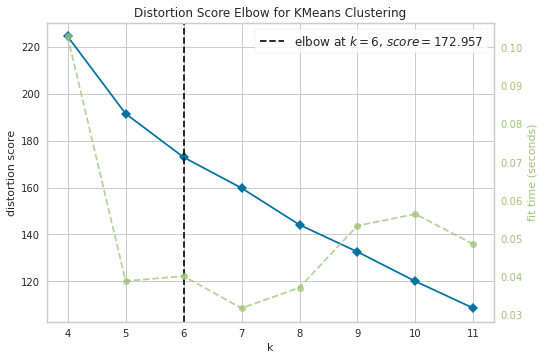

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(X_risiko_scaled)
visualizer.show()

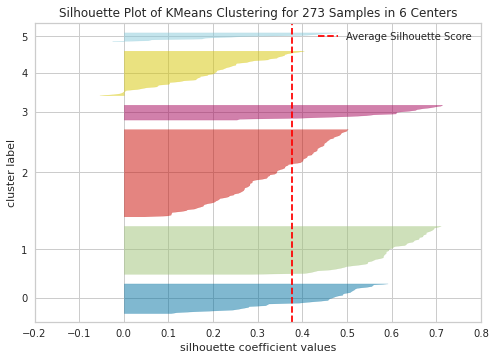

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 273 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [95]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_risiko_scaled)
visualizer.show()

In [96]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_risiko_scaled)

In [99]:
risiko_all_scaled = scaler.transform(df_risiko.iloc[:, 3:].values)
df_risiko["cluster"] = kmeans.predict(risiko_all_scaled)

df_risiko.to_csv("clustered.csv", index=None)
df_risiko.head()

,pemda,nama_pemda,jenis_pemda,risiko_defisit,risiko_mandatory_spending,risiko_keselarasan,cluster
0,KAB KONAWE KEPULAUAN,KAB KONAWE KEPULAUAN,KABUPATEN,100.19,10.13,14.15,1
1,KAB MOROWALI UTARA,KAB MOROWALI UTARA,KABUPATEN,101.56,0.00,21.74,1
2,KAB MUSI RAWAS UTARA,KAB MUSI RAWAS UTARA,KABUPATEN,103.45,0.00,15.97,1
3,ACEH BARAT,KAB. ACEH BARAT,KABUPATEN,104.10,6.08,21.00,1
4,ACEH BARAT DAYA,KAB. ACEH BARAT DAYA,KABUPATEN,111.28,6.86,19.60,1


In [100]:
vis_nonzero = df_risiko[~(df_risiko==0).any(axis=1)]

fig = px.scatter_3d(vis_nonzero, x="risiko_defisit", y="risiko_mandatory_spending", z="risiko_keselarasan", color="cluster", hover_data=["nama_pemda"])
fig.update_layout(autosize=False, height=800, width=1600, margin=dict(l=20, r=20, t=20, b=20))
fig.show()